#### Raw data source: https://www.pet.gov.tw/PetsMap/PetsMap.aspx

#### Setup

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
# from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import requests
import re

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

require("tidyverse")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


#### Playwright scraping 

In [44]:
# "Hey, open up a browser"
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)
page = await browser.new_page()
page.set_default_navigation_timeout(100000)

# Dog registration data
years = [2019] #2020, 2021, 2022, 2023]
for year in years:
    await page.goto("https://www.pet.gov.tw/PetsMap/PetsMap.aspx")
    await page.locator("label").filter(has_text="犬").locator("span").first.click()
    await page.locator("#st").fill(f'{year}/01/01')
    await page.locator("#ed").fill(f'{year}/12/31')
    await page.locator("#setInput").click()

    # await page.get_by_role("button", name="縣 市").click()
    # await page.get_by_role("button", name="縣 市").click()

    html = await page.content()
    doc = BeautifulSoup(html, "html.parser")

    # tables = doc.find_all()")
    # for row in tables:
    #     print(row.a.text)

    # print(table[0])
    # filename = f"text_dog_{year}.csv"

    # print("Saving as", filename)
    # tables[0].to_csv(filename, index=False)


AttributeError: 'NavigableString' object has no attribute 'a'

#### Cleaning and data analysis

In [26]:
# Create average dog per household in DOG registration data

years = [2019, 2020, 2021, 2022, 2023]
for year in years:
    df = pd.read_csv(f"animal_registration_data/{year}_dog.csv", skipinitialspace = True)
   
    # remove whitespaces
    df = df.dropna()
    # df['city'] = df['city'].str.replace(' ','')

    # change the columns to int
    df['registered'] = df['registered'].astype(int)
    df['household'] = df['household'].astype(int)

    # calculate the average dog per household
    df['average_dog'] = (df['registered'] / df['household']).round(2)

    # save the file 
    df.to_csv(f"animal_registration_data/{year}_dog.csv", index=False)



In [7]:
# Create average cat per household in CAT registration data

years = [2019, 2020, 2021, 2022, 2023]
for year in years:
    df = pd.read_csv(f"animal_registration_data/cat/{year}_cat.csv", skipinitialspace = True)

    # change the columns to int
    df['registered'] = df['registered'].astype(int)
    df['household'] = df['household'].astype(int)

    # calculate the average cat per household
    df['average_cat'] = (df['registered'] / df['household']).round(2)

    # save the file back
    df.to_csv(f"animal_registration_data/cat/{year}_cat.csv", index=False)

In [34]:
# Merged the translated city name to the CAT registration data

years = [2019, 2020, 2021, 2022, 2023]

for year in years:

    # load files
    df = pd.read_csv(f"animal_registration_data/cat/{year}_cat.csv", skipinitialspace = True) # check the filename!!!
    df_city = pd.read_csv("city.csv")

    # merge number files with traslated city name file
    merged = pd.merge(df, df_city, left_on='city', right_on='Mandarin', how='left')

    # drop the duplicated column
    merged.drop(columns=['Mandarin'], inplace=True)

    # print(merged) # > check if the merge is correct

    # save back to the file
    merged.to_csv(f"animal_registration_data/cat/{year}_cat.csv", index=False) # filename!!!

In [37]:
# Merged the translated city name to the DOG registration data

years = [2019, 2020, 2021, 2022, 2023]

for year in years:

    # load files
    df = pd.read_csv(f"animal_registration_data/dog/{year}_dog.csv", skipinitialspace = True) # filename!!!
    df_city = pd.read_csv("city.csv")

    # merge number files with traslated city name file
    merged = pd.merge(df, df_city, left_on='city', right_on='Mandarin', how='left')

    # drop the duplicated column
    merged.drop(columns=['Mandarin'], inplace=True)

    # print(merged) # > check if the merge is correct

    # save back to the file
    merged.to_csv(f"animal_registration_data/dog/{year}_dog.csv", index=False) # filename!!!

In [13]:
# 2023 top 10 cities with the most registered dogs and cats

df2023_dog = pd.read_csv("animal_registration_data/dog/2023_dog.csv", skipinitialspace = True) # filename!!!
df2023_cat = pd.read_csv("animal_registration_data/cat/2023_cat.csv", skipinitialspace = True) # filename!!!
merged = pd.merge(df2023_dog, df2023_cat, on='city', how='left')
merged.drop(columns=['household_x', 'registered_x', 'registered_y', 'household_y', 'English_x'], inplace=True)
merged.to_csv("animal_registration_data/2023_average_CND.csv", index=False)

<Axes: ylabel='English'>

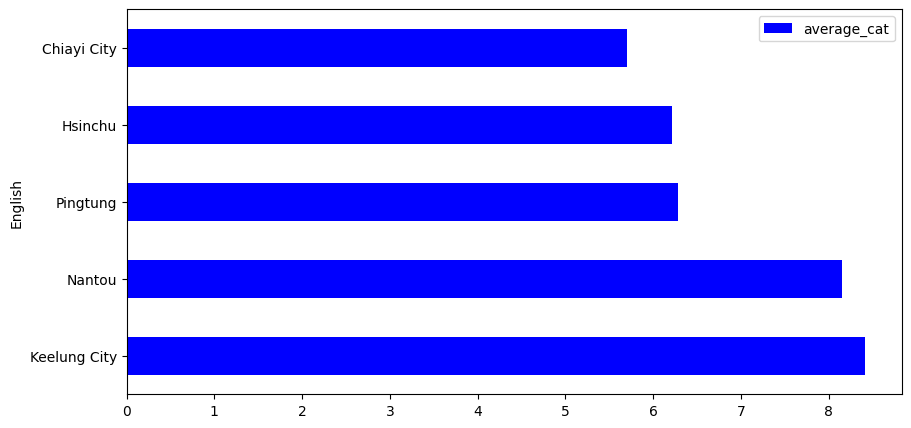

In [41]:
merged[['average_cat','English']].sort_values('average_cat', ascending=False).head(5).plot.barh(x='English', y='average_cat', color='blue', figsize=(10, 5))

<Axes: ylabel='English'>

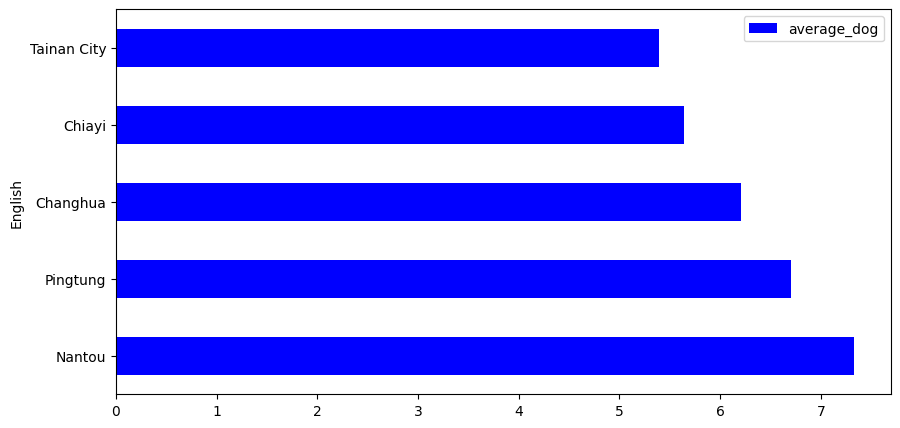

In [25]:
# Top 5 cities with the most registered dogs in 2023
merged[['average_dog','English']].sort_values('average_dog', ascending=False).head(5).plot.barh(x='English', y='average_dog', color='blue', figsize=(10, 5))

In [38]:
# Top 5 cities with the most registered cats and dogs in 2023
top5_cat = merged.sort_values('average_cat', ascending=False).head(5)
top5_dog = merged.sort_values('average_dog', ascending=False).head(5)
top5_cat_city = list(top5_cat.English.unique())
top5_dog_city = list(top5_dog.English.unique())
top_animal_cities = list(set(top5_cat_city + top5_dog_city))


In [40]:
top2023 = merged[merged['English'].isin(top_animal_cities)==True]
top2023.to_csv("animal_registration_data/2023_top5_CND.csv", index=False)
